In [1]:
from PIL import Image
import numpy as np 
import os 
import random

import numpy as np
import matplotlib.pyplot as pl
import torch
import ot
import ot.plot

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib ipympl
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # has not effect

import sys
sys.path.append("../")
device="cuda"
from tqdm import tqdm_notebook as tqdm

from gaussian_renderer import render, network_gui
from arguments import ModelParams, PipelineParams, OptimizationParams
import argparse
from scene import Scene, GaussianModel
from random import randint
from argparse import ArgumentParser, Namespace

saving_steps = [1, 100, 300, 1_000, 3_000, 7_000, 10_000, 15_000, 20_000, 30_000]
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--save_iterations", nargs="+", type=int, default=saving_steps)
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=saving_steps)# default=[])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(("-s /home/dimakot55/data/nerf_synthetic/hotdog/ "+\
                         "--model_path /home/dimakot55/workspace/gaussian-splatting/notebooks/GT_lego_cluster2_test_notebook14/").split())#sys.argv[1:])
#args.save_iterations.append(args.iterations)
dataset=lp.extract(args)
pipe=pp.extract(args)
opt=op.extract(args)
os.makedirs(args.model_path, exist_ok=True)

In [2]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])



In [3]:

# Functions from @Mateen Ulhaq and @karlo for visualizing 3d points with equal scaling of axes
def set_axes_equal(ax: plt.Axes):
    """Set 3D plot axes to equal scale.

    Make axes of 3D plot have equal scale so that spheres appear as
    spheres and cubes as cubes.  Required since `ax.axis('equal')`
    and `ax.set_aspect('equal')` don't work on 3D.
    """
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    _set_axes_radius(ax, origin, radius)

def _set_axes_radius(ax, origin, radius):
    x, y, z = origin
    ax.set_xlim3d([x - radius, x + radius])
    ax.set_ylim3d([y - radius, y + radius])
    ax.set_zlim3d([z - radius, z + radius])



# Load content scene

In [4]:
os.makedirs(args.model_path, exist_ok=True)
content_gaussians = GaussianModel(3)
content_scene = Scene(dataset, content_gaussians, shuffle=False)
content_gaussians.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [5]:
! ls /home/dimakot55/output_data/content_scenes_fitted/

GT_chair  GT_drums  GT_ficus  GT_hotdog  GT_lego  GT_materials	GT_mic	GT_ship


In [17]:
content_gaussians.restore(torch.load("/home/dimakot55/output_data/content_scenes_fitted/GT_hotdog/chkpnt30000.pth")[0], opt)


In [12]:

bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device=device)
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
#viewpoint_cam = viewpoint_stack.pop(4) # 6, 2, 4, 5, 7


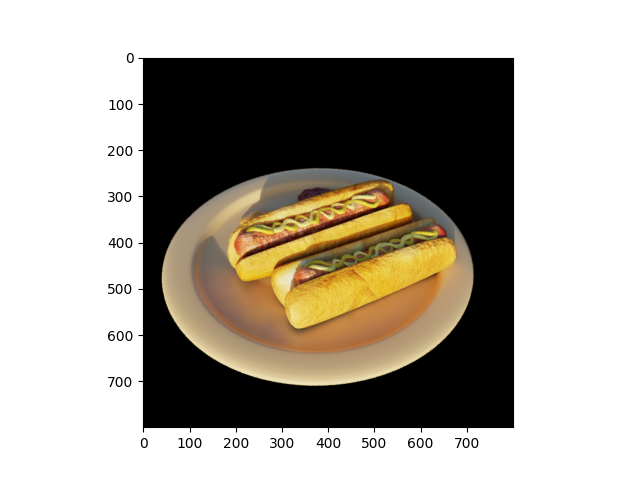

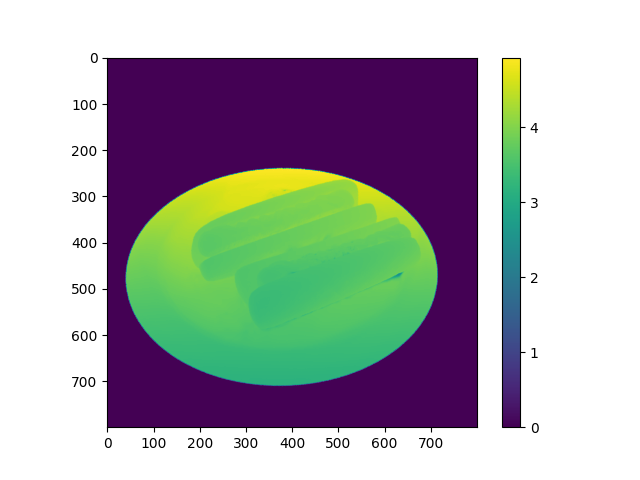

In [13]:

render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


depth_np = depth_cont.detach().cpu().numpy()

plt.figure()
plt.imshow(depth_np)
plt.colorbar()
plt.show()


In [10]:
# content_gaussians._opacity.data +=  1e6
# content_gaussians_features_ds_original = content_gaussians._features_dc.detach().clone()
# content_gaussians._features_dc.data = content_gaussians._xyz.data.clone().detach().unsqueeze(1)
# content_gaussians._features_rest.data = content_gaussians._features_rest.data * 0.



# render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
# image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

# image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
# plt.figure()
# plt.imshow(image_rgb)
# plt.show()

# Gaussians for optimization

In [9]:
gaussians_opt = GaussianModel(3)
scene_opt = Scene(dataset, gaussians_opt, shuffle=True)
gaussians_opt.training_setup(opt)

Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms
Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000


In [86]:
gaussians_opt.restore(torch.load("/home/dimakot55/output_data/notebooks_data/fit_hotdog_pebbles_preselect_gaussians_larger_init_converged2/chkpnt1.pth")[0], opt)


In [71]:
gaussians_opt_features_dc_original = gaussians_opt._features_dc.data.detach().clone()
gaussians_opt_features_rest_original = gaussians_opt._features_rest.data.detach().clone()

In [ ]:

with torch.no_grad():
    gaussians_opt._features_dc.data = gaussians_opt._xyz.data.clone().detach().unsqueeze(1)
    gaussians_opt._features_rest.data = gaussians_opt._features_rest.data * 0.

In [23]:
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

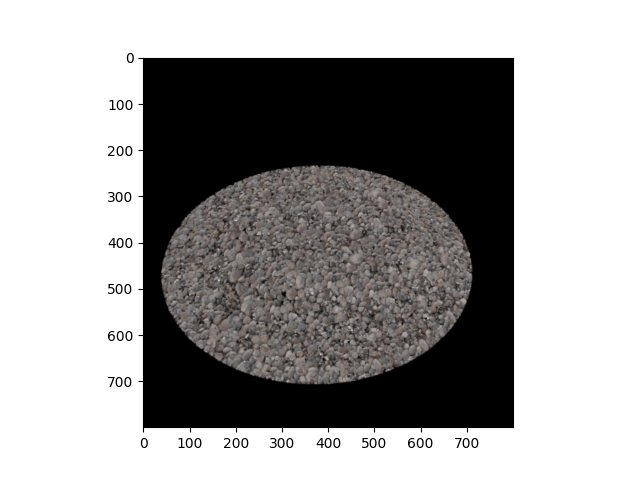

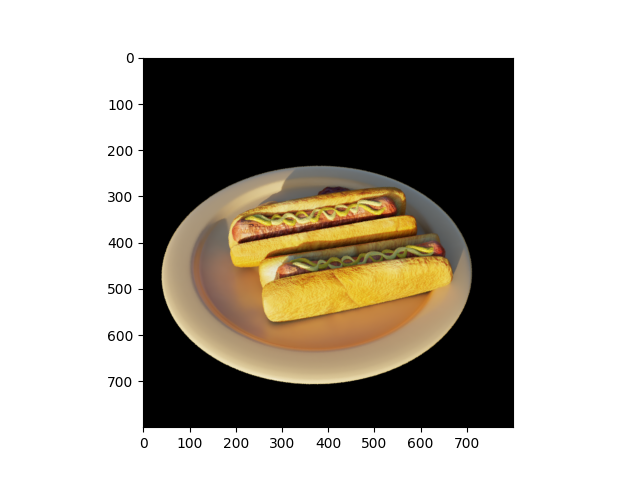

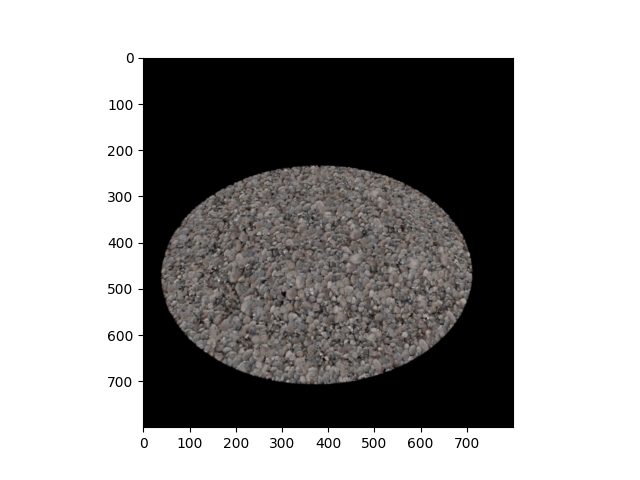

In [88]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()






gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data *= 0.

In [89]:


gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()

In [25]:
import pickle
with open('/home/dimakot55/output_data/notebooks_data/results_hotdog_SAM2.pkl', 'rb') as handle:
    results = pickle.load(handle)

/tmp/ipykernel_810324/2618477430.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][idx]*(2**idx)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


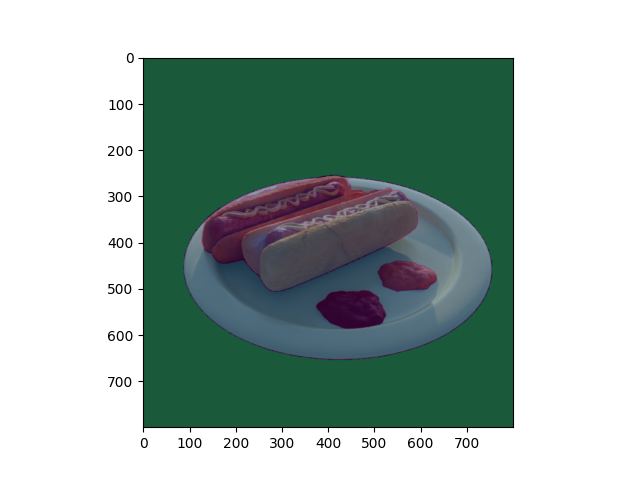

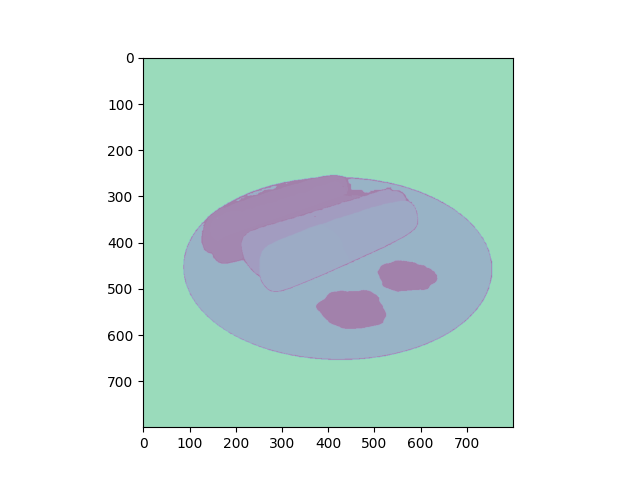

In [26]:
viewpoint_cam_idx = 10
summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][idx]*(2**idx) 
                      for idx in range(len(results[viewpoint_cam_idx]["masks"])))
plt.figure()
plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()

plt.figure()
#plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()



In [27]:
lbls_surrogate, lbls_surrogate_count = np.unique(summed_masks,return_counts=True)
masks_surrogate = [summed_masks==lbl for lbl in np.unique(summed_masks)]

# remove zeros and remove those classes that are almost absent
idcs_to_leave = np.where(lbls_surrogate_count > 20*20)[0]
idcs_to_leave = [idx for idx in idcs_to_leave if lbls_surrogate[idx]!=0]

masks_surrogate=[masks_surrogate[idx] for idx in np.array(idcs_to_leave)]
lbls_surrogate=[lbls_surrogate[idx] for idx in np.array(idcs_to_leave)]


In [39]:

import cv2
import skimage
edges = None
for mask in masks_surrogate:
    
    mask = np.array(mask).astype(np.uint8)*255
    if edges is not None:
        edges = edges + cv2.Canny(mask, 30, 200) 
    else:
        edges = cv2.Canny(mask, 30, 200) 
        

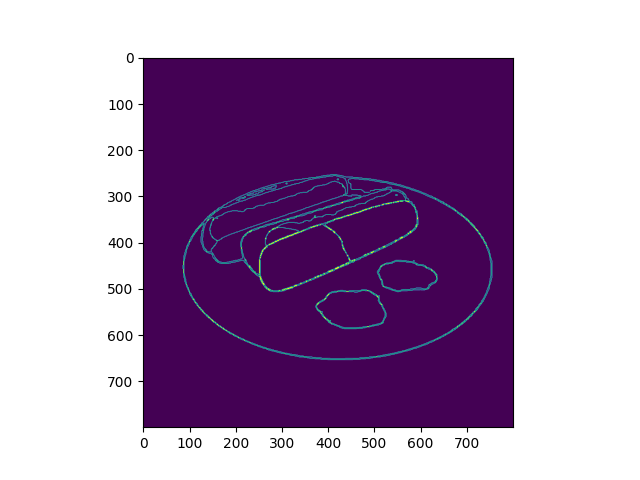

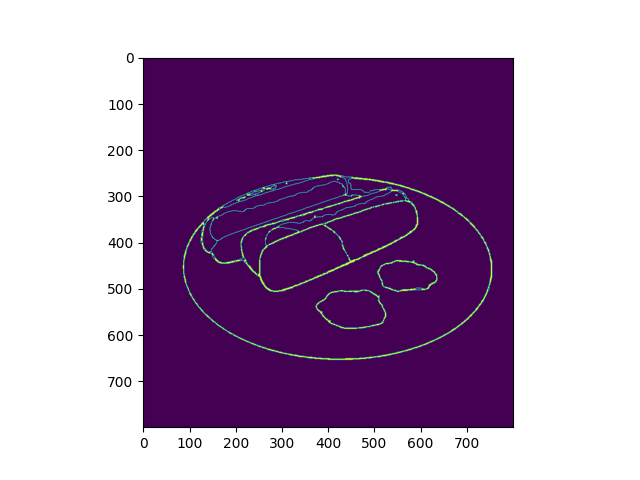

In [51]:
plt.figure()
plt.imshow(edges)
plt.show()

edges_processed = skimage.morphology.isotropic_dilation(edges>0, radius=1)
edges_processed = skimage.morphology.isotropic_erosion(edges_processed, radius=1)
plt.figure()
plt.imshow(edges_processed)
plt.show()



In [52]:
losses_full=[]
losses_pixel = []
losses_reg = []
losses_tv = []
losses_loc_descr = []
losses_loc_descr_fine = []
losses_pixel_edges = []


gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4

# Old version
gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = True
gaussians_opt._rotation.requires_grad = True
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = True


# New version
gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False


In [53]:
edges_mask = torch.tensor(edges_processed,dtype=torch.float32).to("cuda").unsqueeze(0)

In [54]:

for step in tqdm(range(5001)):
    gaussians_opt.optimizer.zero_grad()
    # Take specific camera
    viewpoint_cam = results[viewpoint_cam_idx]["viewpoint_cam"]
    # Render content and style images
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]
    loss_pixel_edges = torch.mean(torch.square(image_cont - image) * edges_mask)
    

    
    # loss = loss_pixel * 5e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 1e7 #+ loss_descriptor_local_fine * 4e6 # was 1e4
    loss = loss_pixel_edges * 5e3 # 5e4
    loss.backward()

    gaussians_opt.optimizer.step()
    losses_full.append(float(loss.detach().cpu().numpy()))
    
    losses_pixel_edges.append(float(loss_pixel_edges.detach().cpu().numpy()))
    



    
    

    if step % 100 == 0:
        print(f"l_pixel_edges:{loss_pixel_edges:.7f},",
              f"l:{loss:.7f}")
  

/tmp/ipykernel_810324/1763543095.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_pixel_edges:0.0013114, l:6.5569530
l_pixel_edges:0.0001419, l:0.7095428
l_pixel_edges:0.0001067, l:0.5333439


KeyboardInterrupt: 

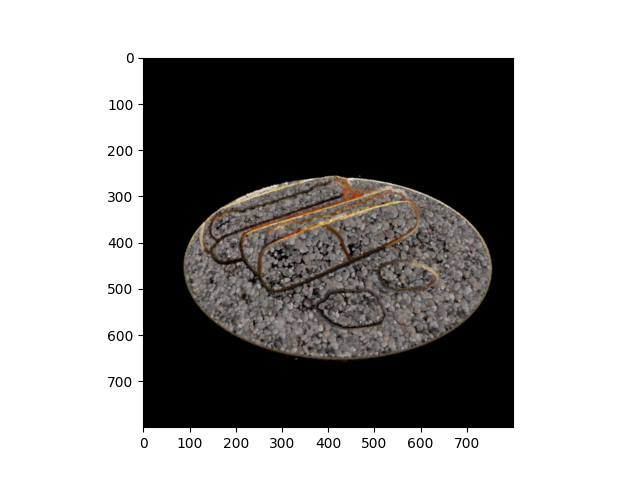

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


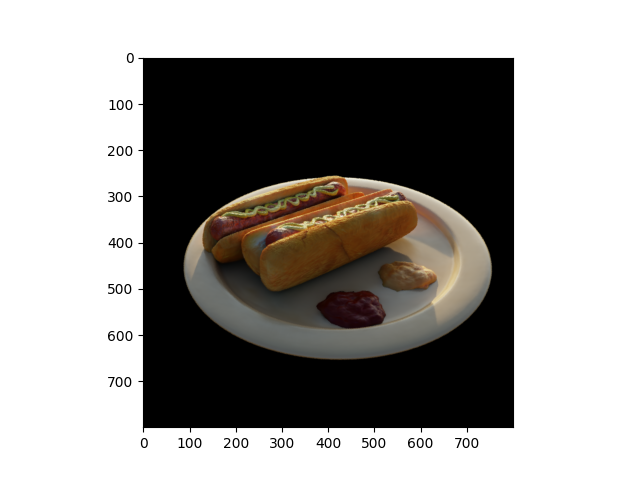

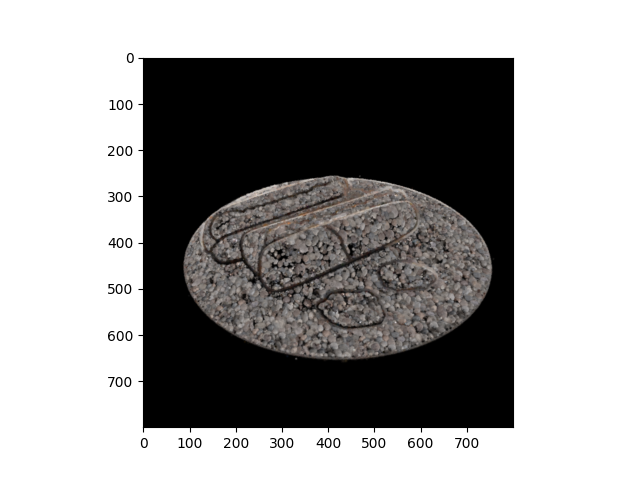

NameError: name 'gaussians_opt_features_dc_fitted' is not defined

In [55]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()






gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


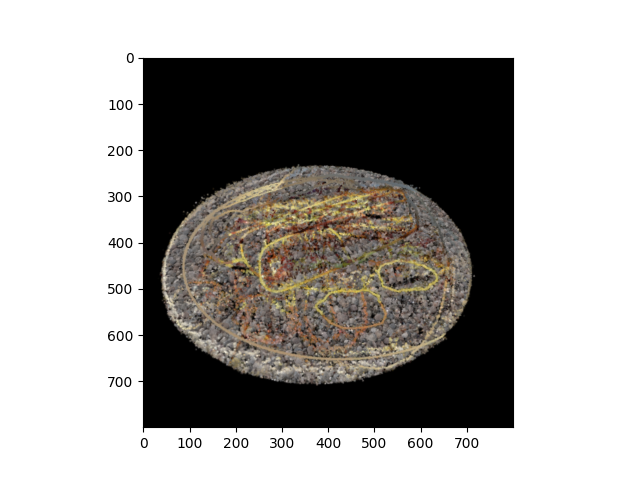

In [85]:

# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

In [ ]:
gaussians_opt_features_dc_fitted = gaussians_opt._features_dc.data.detach().clone()

In [57]:


gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()*1.

import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/' 
# MODEL_DIR_NEW = './fit_hotdog_with_rose_bush_lego_coast_rocks_fitted_with_masks_orig_scaling/'
MODEL_DIR_NEW = './fit_hotdog_pebbles_stage2_2/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))

gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.


NameError: name 'gaussians_opt_features_dc_fitted' is not defined

# Now optimize for a few views

In [59]:
import pickle
with open('/home/dimakot55/output_data/notebooks_data/results_hotdog_SAM2.pkl', 'rb') as handle:
    results = pickle.load(handle)

/tmp/ipykernel_810324/3780119136.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][idx]*(2**idx)


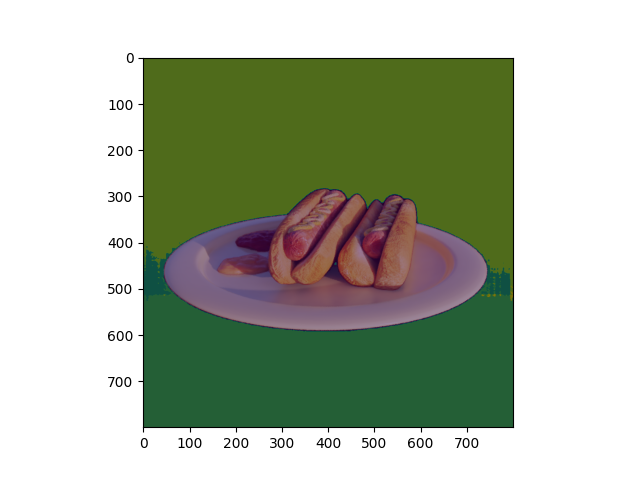

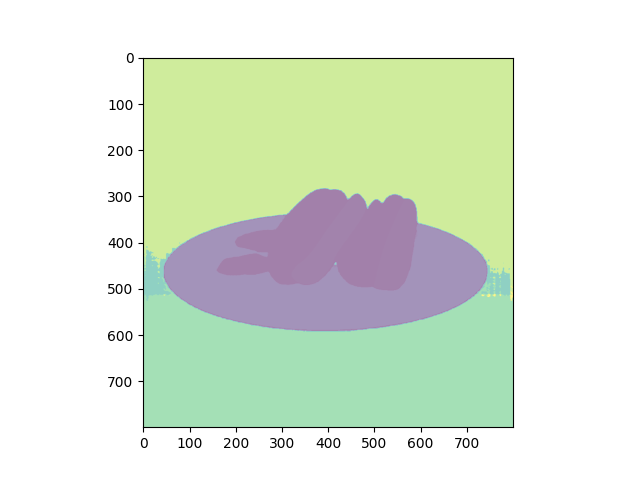

In [69]:
viewpoint_cam_idx = 35
summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][idx]*(2**idx) 
                      for idx in range(len(results[viewpoint_cam_idx]["masks"])))
plt.figure()
plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()

plt.figure()
#plt.imshow(results[viewpoint_cam_idx]["image_rgb"])
plt.imshow(summed_masks, alpha=0.5)
plt.show()



In [190]:
import cv2
import skimage
viewpoint_cam_idx_list = [0, 10, 20, 25, 35]
viewpoint_cam_idx_list = viewpoint_cam_idx_list

for viewpoint_cam_idx in viewpoint_cam_idx_list:
    summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][idx]*(2**idx) 
                      for idx in range(len(results[viewpoint_cam_idx]["masks"])))
    
    lbls_surrogate, lbls_surrogate_count = np.unique(summed_masks,return_counts=True)
    masks_surrogate = [summed_masks==lbl for lbl in np.unique(summed_masks)]
    
    # remove zeros and remove those classes that are almost absent
    idcs_to_leave = np.where(lbls_surrogate_count > 20*20)[0]
    idcs_to_leave = [idx for idx in idcs_to_leave if lbls_surrogate[idx]!=0]
    
    masks_surrogate=[masks_surrogate[idx] for idx in np.array(idcs_to_leave)]
    lbls_surrogate=[lbls_surrogate[idx] for idx in np.array(idcs_to_leave)]
    
    edges = None
    for mask in masks_surrogate:
        
        mask = np.array(mask).astype(np.uint8)*255
        if edges is not None:
            edges = edges + cv2.Canny(mask, 30, 200) 
        else:
            edges = cv2.Canny(mask, 30, 200)
    
    
    edges_processed = skimage.morphology.isotropic_dilation(edges>0, radius=1)
    edges_processed = skimage.morphology.isotropic_erosion(edges_processed, radius=1)
    
    results[viewpoint_cam_idx]["edges"] = torch.tensor(edges_processed,dtype=torch.float32).to("cuda").unsqueeze(0)

    # Render original frame and use it as loss as well
    viewpoint_cam = results[viewpoint_cam_idx]["viewpoint_cam"]
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]

    results[viewpoint_cam_idx]["texture"] = torch.tensor(image,dtype=torch.float32).to("cuda")
            

/tmp/ipykernel_810324/2682277294.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  summed_masks = np.sum(results[viewpoint_cam_idx]["masks"][idx]*(2**idx)
/tmp/ipykernel_810324/2682277294.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  results[viewpoint_cam_idx]["texture"] = torch.tensor(image,dtype=torch.float32).to("cuda")


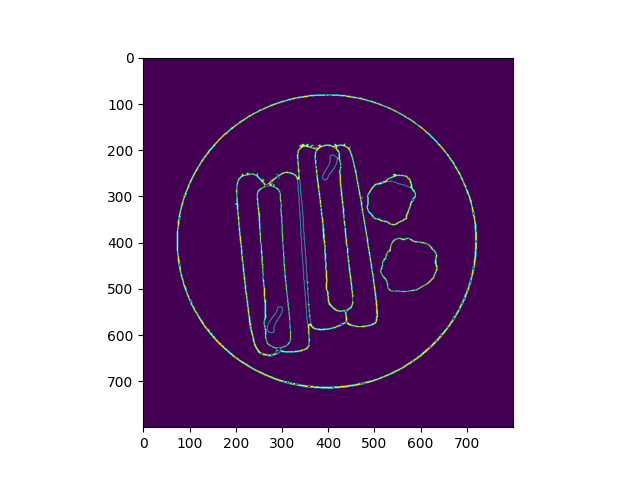

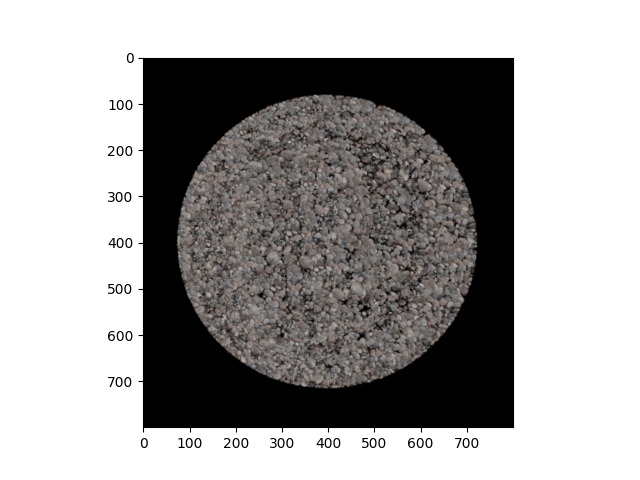

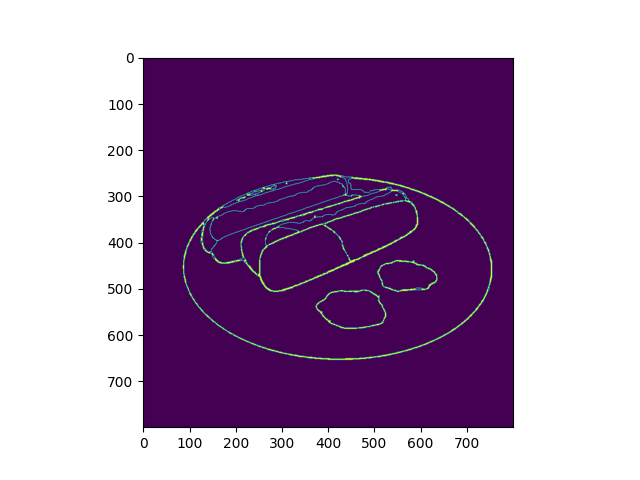

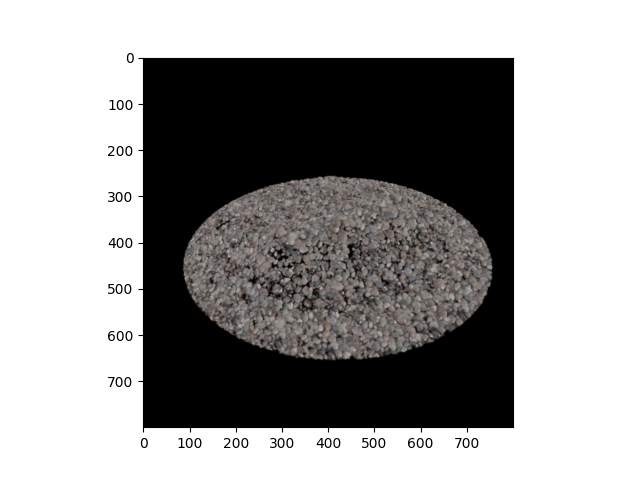

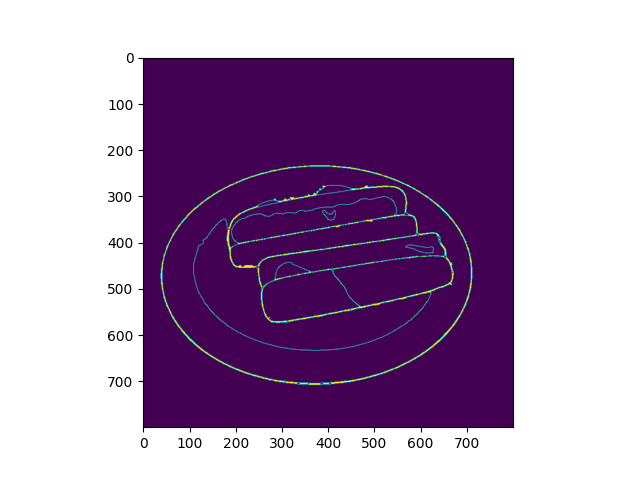

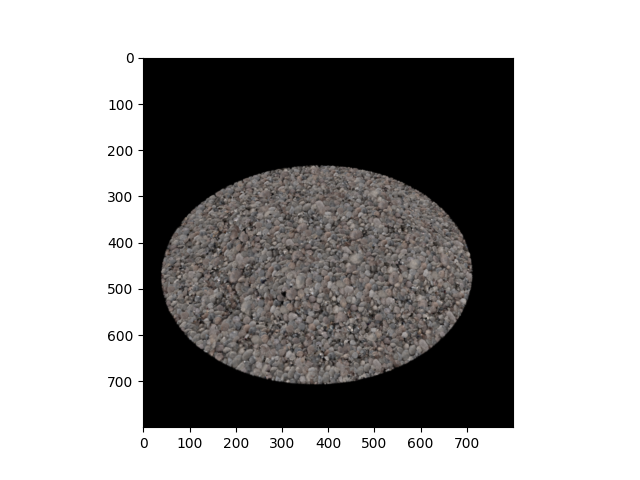

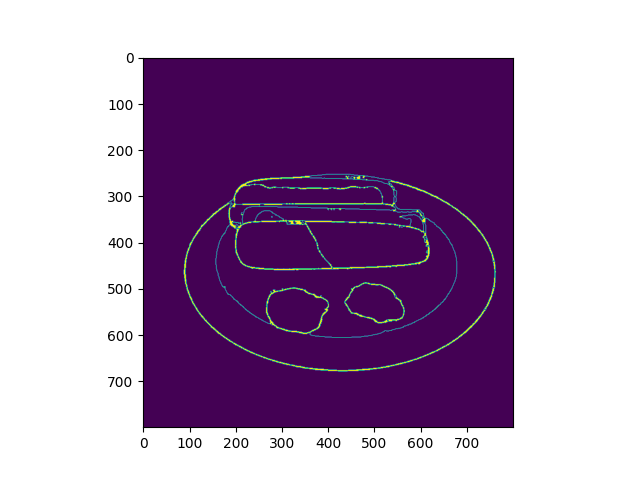

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


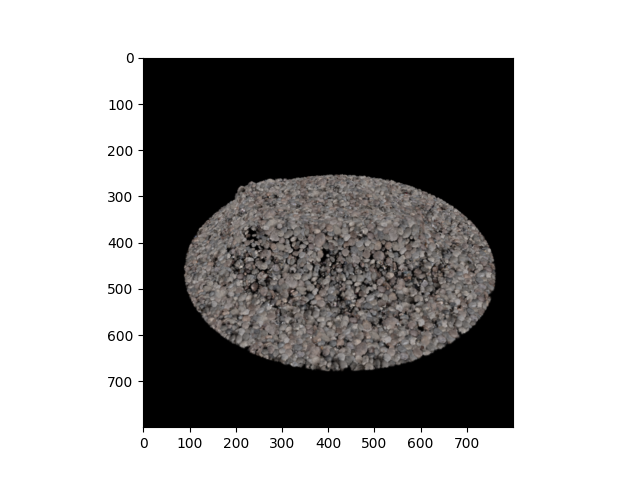

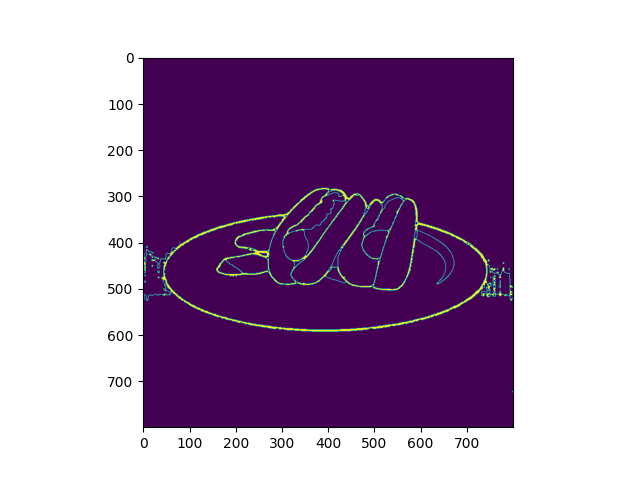

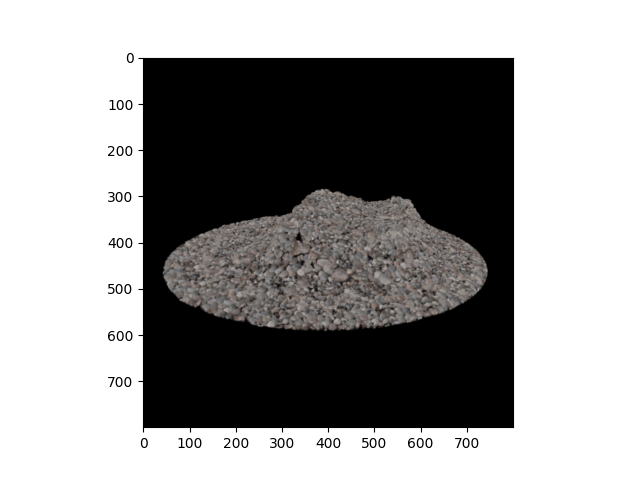

In [136]:
for viewpoint_cam_idx in viewpoint_cam_idx_list:
    
    image_rgb = results[viewpoint_cam_idx]["edges"].detach().cpu().numpy()[0]
    plt.figure()
    plt.imshow(image_rgb)
    plt.show()

    image_rgb = results[viewpoint_cam_idx]["texture"].detach().cpu().numpy().transpose(1,2,0)
    plt.figure()
    plt.imshow(image_rgb)
    plt.show()

In [231]:
gaussians_opt.restore(torch.load("/home/dimakot55/output_data/notebooks_data/fit_hotdog_pebbles_preselect_gaussians_larger_init_converged2/chkpnt1.pth")[0], opt)


In [232]:
losses_full=[]
losses_pixel = []
losses_reg = []
losses_tv = []
losses_loc_descr = []
losses_loc_descr_fine = []
losses_pixel_edges = []


gaussians_opt.training_setup(opt)
# for param_group in gaussians_opt.optimizer.param_groups:
#         param_group['lr'] = 1e-4

# Old version
gaussians_opt._xyz.requires_grad = True
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = True
gaussians_opt._rotation.requires_grad = True
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = True


# New version
gaussians_opt._xyz.requires_grad = False
gaussians_opt._features_dc.requires_grad = True
gaussians_opt._features_rest.requires_grad = False
gaussians_opt._scaling.requires_grad = False
gaussians_opt._rotation.requires_grad = False
gaussians_opt._opacity.requires_grad = False
gaussians_opt.max_radii2D.requires_grad = False


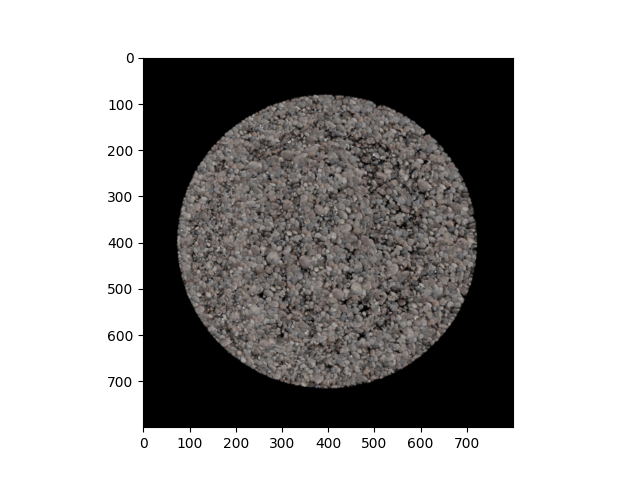

In [233]:

# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

In [242]:

for step in tqdm(range(5001)):
    viewpoint_cam_idx = random.choice(viewpoint_cam_idx_list)
    gaussians_opt.optimizer.zero_grad()
    # Take specific camera
    edges_mask = results[viewpoint_cam_idx]["edges"]
    viewpoint_cam = results[viewpoint_cam_idx]["viewpoint_cam"]
    # Render content and style images
    render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
    image, depth= render_pkg["render"], render_pkg["depth"]
    render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
    image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]

    target_texture = results[viewpoint_cam_idx]["texture"]
    # loss_pixel_edges = torch.mean(torch.square(image) * edges_mask)
    loss_pixel_edges = torch.mean(torch.square(image-image_cont))
    loss_pixel_texture = torch.mean(torch.square(target_texture - image))
    
    
    
    # loss = loss_pixel * 5e1  + l_tv * 0e-5 + l_reg * 1e1 + loss_descriptor_local * 1e7 #+ loss_descriptor_local_fine * 4e6 # was 1e4
    loss = loss_pixel_edges * 5e3 + loss_pixel_texture * 1e6
    loss.backward()

    gaussians_opt.optimizer.step()
    losses_full.append(float(loss.detach().cpu().numpy()))
    
    losses_pixel_edges.append(float(loss_pixel_edges.detach().cpu().numpy()))
    



    
    

    if step % 100 == 0:
        print(f"l_pixel_edges:{loss_pixel_edges:.7f}, loss_pixel_texture:{loss_pixel_texture:.7f},",
              f"l:{loss:.7f}")
  

/tmp/ipykernel_810324/3734454604.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(5001)):


  0%|          | 0/5001 [00:00<?, ?it/s]

l_pixel_edges:0.0290008, loss_pixel_texture:0.0018083, l:1953.2977295
l_pixel_edges:0.0290554, loss_pixel_texture:0.0017442, l:1889.4580078
l_pixel_edges:0.0290343, loss_pixel_texture:0.0016353, l:1780.4608154
l_pixel_edges:0.0257414, loss_pixel_texture:0.0022769, l:2405.5708008
l_pixel_edges:0.0257149, loss_pixel_texture:0.0021661, l:2294.6357422
l_pixel_edges:0.0257754, loss_pixel_texture:0.0021566, l:2285.4362793
l_pixel_edges:0.0146026, loss_pixel_texture:0.0016006, l:1673.6466064
l_pixel_edges:0.0151990, loss_pixel_texture:0.0016374, l:1713.3850098
l_pixel_edges:0.0182905, loss_pixel_texture:0.0013127, l:1404.1644287
l_pixel_edges:0.0292852, loss_pixel_texture:0.0014939, l:1640.3068848
l_pixel_edges:0.0182639, loss_pixel_texture:0.0012328, l:1324.1181641
l_pixel_edges:0.0152061, loss_pixel_texture:0.0015938, l:1669.8457031
l_pixel_edges:0.0146188, loss_pixel_texture:0.0015382, l:1611.2593994
l_pixel_edges:0.0152343, loss_pixel_texture:0.0015797, l:1655.8657227


KeyboardInterrupt: 

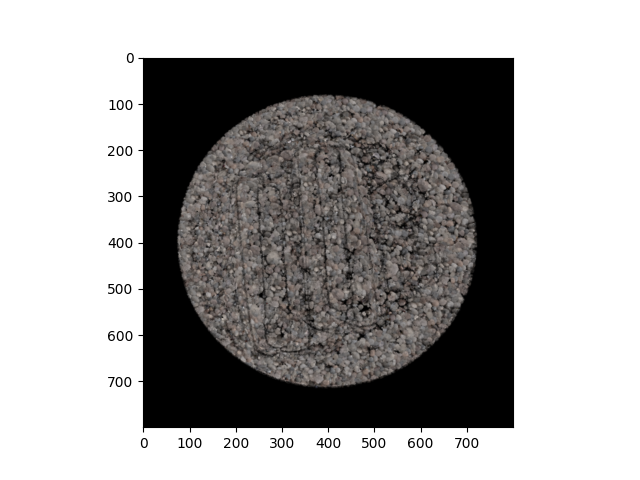

In [243]:

# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

In [254]:
viewpoint_stack = content_scene.getTrainCameras().copy()
viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))

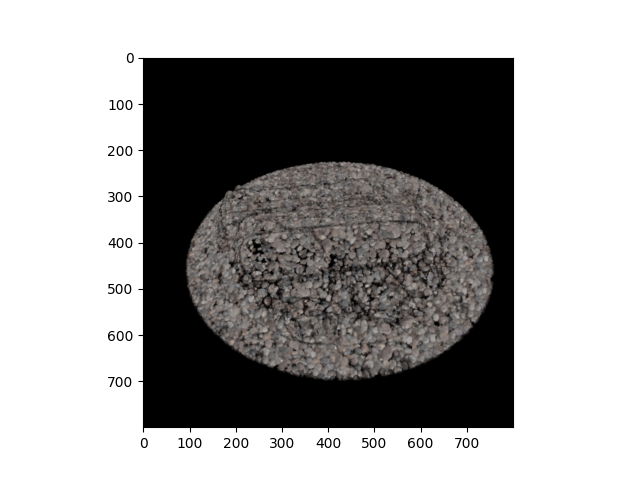

In [255]:

# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()

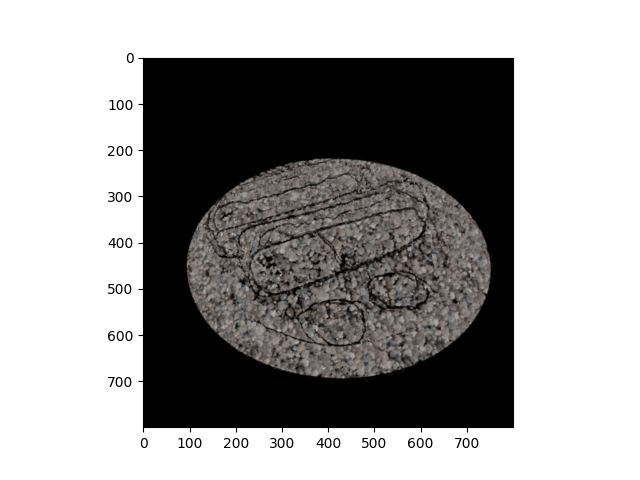

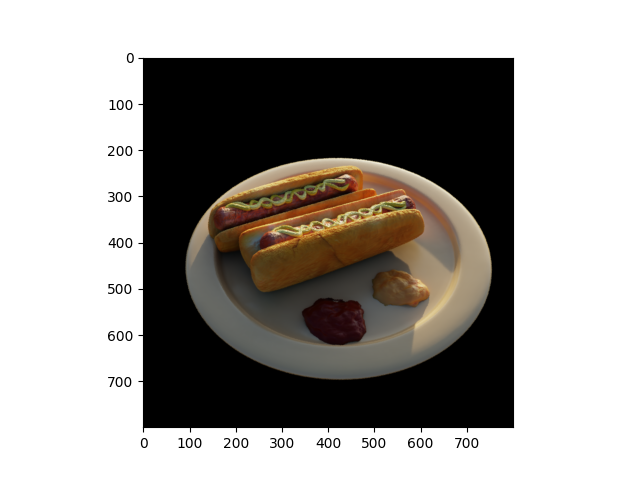

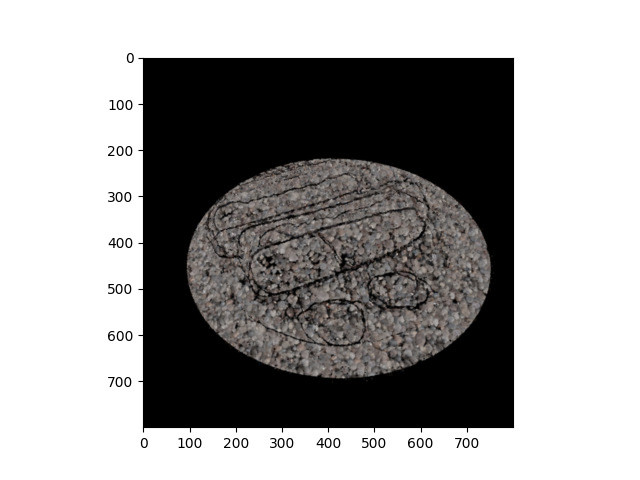

NameError: name 'gaussians_opt_features_dc_fitted' is not defined

In [198]:
SCALING_FACTOR = 1.
# Sample camera

gaussians_opt._scaling.data /=  SCALING_FACTOR





# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()
image_rgb = image_cont.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()






gaussians_opt._features_dc.data = gaussians_opt_features_dc_original.clone()
gaussians_opt._features_rest.data = gaussians_opt_features_rest_original.clone()


# Render
render_pkg = render(viewpoint_cam, gaussians_opt, pipe, background)
image, depth= render_pkg["render"], render_pkg["depth"]
render_pkg_cont = render(viewpoint_cam, content_gaussians, pipe, background)
image_cont, depth_cont= render_pkg_cont["render"], render_pkg_cont["depth"]


# Visualize
image_rgb = image.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure()
plt.imshow(image_rgb)
plt.show()


gaussians_opt._features_dc.data = gaussians_opt_features_dc_fitted.clone()
gaussians_opt._features_rest.data *= 0.

In [224]:

import sys
sys.path.append("../")

from scene import GaussianModel
MODEL_DIR = './dummy_scene/' 
# MODEL_DIR_NEW = './fit_hotdog_with_rose_bush_lego_coast_rocks_fitted_with_masks_orig_scaling/'
MODEL_DIR_NEW = './fit_hotdog_pebbles_stage2_4/'
os.makedirs(MODEL_DIR_NEW, exist_ok = True)

! cp -r {MODEL_DIR}* {MODEL_DIR_NEW}
# ls MODEL_DIR


iteration=1
torch.save((gaussians_opt.capture(), iteration), MODEL_DIR_NEW + "/chkpnt" + str(iteration) + ".pth")
gaussians_opt.save_ply(os.path.join(MODEL_DIR_NEW, "point_cloud/iteration_1/", "point_cloud.ply"))
